# Cosmology Computational Project
## Analysis Compare CMB power spectrum of Theory and data
in this notebook, I'll walk through the analysis of the ACT_DR5_f150 map, the first thing we want to do is to compare the power spectrum of theory and real data. This follow the Summer school notebook 6-7 

<font color='#33a994'>This is teal text.</font>

In [1]:
!python -c "import cmb_modules" || ( \
    wget https://github.com/jeffmcm1977/CMBAnalysis_SummerSchool/raw/master/cmb_school.tar.gz && \
    tar xzvf cmb_school.tar.gz \
)

# Import constants and define variables

In [3]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

import constants as cs # the constants module
import cmb_modules # the module of functions

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = cs.atmospheric_noise_level
one_over_f_noise_level = cs.one_over_f_noise_level

# Import ACT_DR5 data and define the pixel size according to header 

In [4]:
map = fits.getdata('/Users/yi/Documents/CMB_SZ/act_dr5.01_s08s18_AA_f150_daynight_map.fits')
header = fits.getheader('/Users/yi/Documents/CMB_SZ/act_dr5.01_s08s18_AA_f150_daynight_map.fits')
ra0 = -180  ## Sky ccoverage of DR5 
ra1 = 180
dec0 = -63
dec1 = 23
Nx= header['NAXIS1']
Ny= header['NAXIS2']
Box_side = 500     # this is the size of the map patches 

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins

map = map[0]  # take the first frame of CMB file

0.5 0.5


In [5]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                43200                                                  
NAXIS2  =                10320                                                  
NAXIS3  =                    3                                                  
CRPIX1  =              21601.0 / Pixel coordinate of reference point            
CRPIX2  =               7561.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =  -0.0083333333333333 / [deg] Coordinate increment at reference point  
CDELT2  =   0.0083333333333333 / [deg] Coordinate increment at reference point  
CDELT3  =                  1.0 / Coordinate increment at reference point        
CUNIT1  = 'deg'             

# plotting the DR5 map

map mean: -0.79496956 map rms: 162.88133


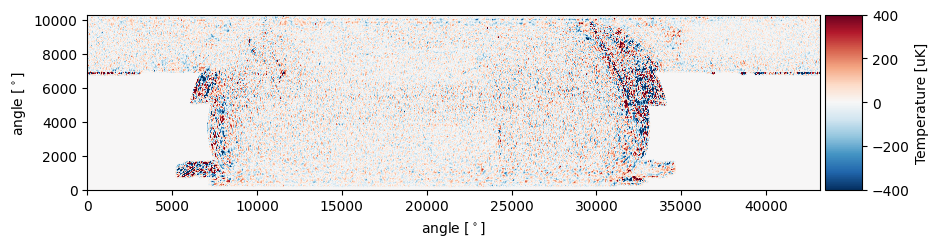

In [6]:
plt.figure(figsize=(20,20))
p = cmb_modules.Plot_CMB_Map(map,c_min,c_max,Nx,Ny)

# Cutting map patches and make a appodized map 

In [7]:
N=int(500) # take only one dimension
map_patch = map[N:2*int(N), Ny-2*N:Ny-N] #trimming the map down to size

map mean: -1.9485154749790254 map rms: 61.421140056313476


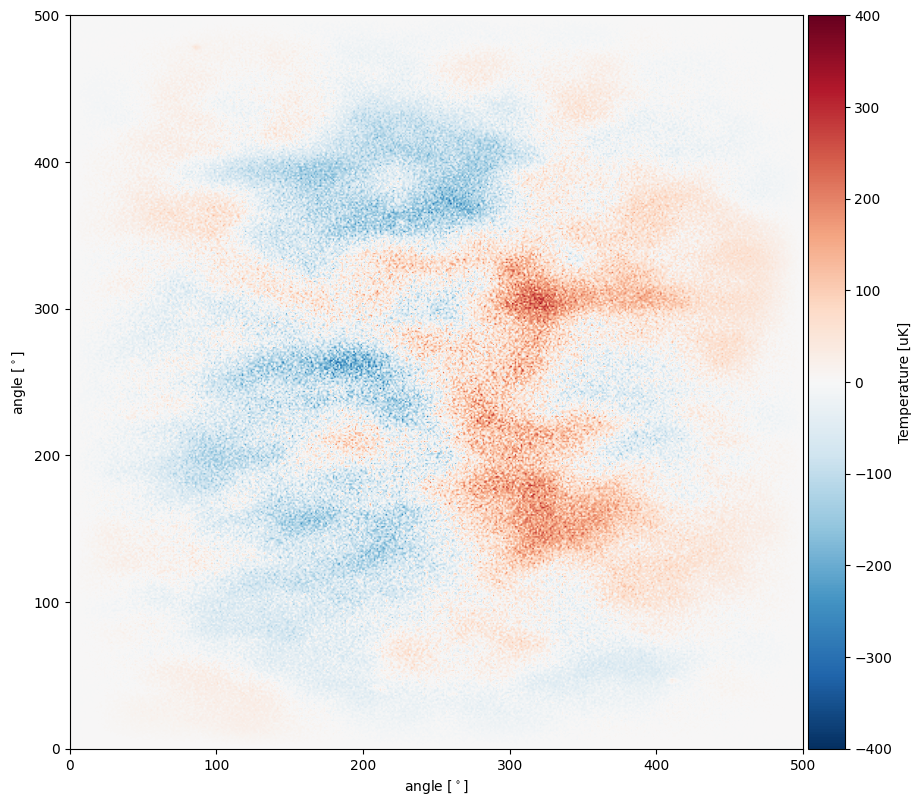

In [8]:
# Making a window function, taking the shorter dimension for now
window = (cmb_modules.cosine_window(N))
appodized_map = window * map_patch
p=cmb_modules.Plot_CMB_Map(appodized_map,c_min,c_max,N, N)

# Get a modeled CMB map with point source, SZ map, noise, and convoled with insrument beam

/Users/yi/Documents/GitHub/Cosmology_Technical_project/cmb_modules.py:15: RuntimeWarning: invalid value encountered in divide
  ClTT = DlTT * 2 * np.pi / (ell * (ell + 1.0))


Number of sources required:  5000
map mean: -14.825744086922334 map rms: 46.71011214602408


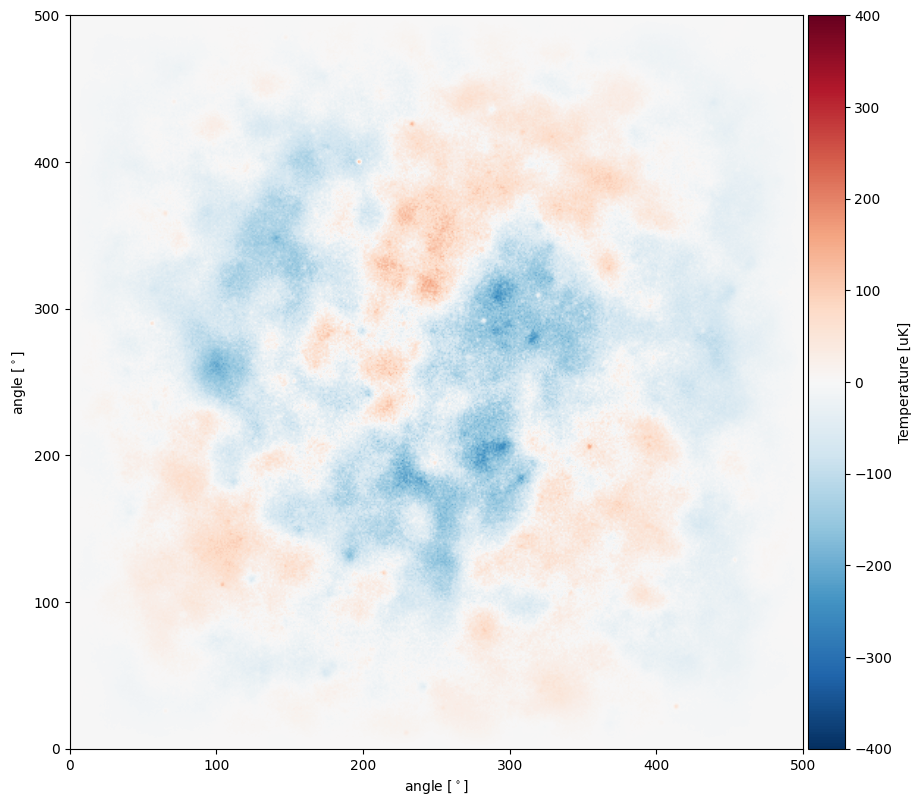

In [9]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 

CMB_T = cmb_modules.make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = cmb_modules.Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap += cmb_modules.Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = cmb_modules.SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorperate the impact of the instrument
    ## beam
CMB_T_convolved = cmb_modules.convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = cmb_modules.make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

## plot the result
#p = cmb_modules.Plot_CMB_Map(total_map_plus_noise,c_min,c_max,N,N)

appodized_theory_map = window * total_map_plus_noise

p = cmb_modules.Plot_CMB_Map(appodized_theory_map,c_min,c_max,N, N)

# Calculate the auto-correlation power spectrum of CMB data and theory 

/opt/anaconda3/envs/my_x86_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/my_x86_env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


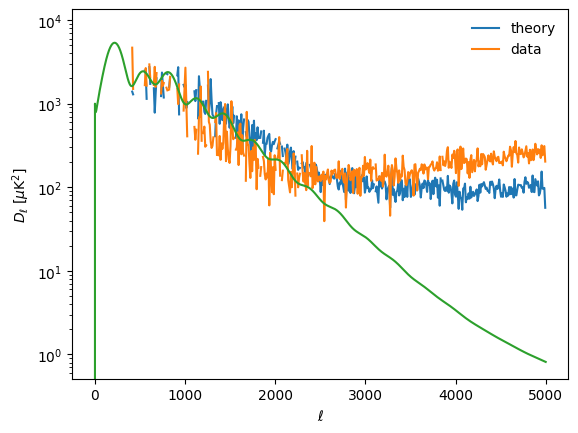

In [10]:
#### parameters for setting up the spectrum
delta_ell = 10# cs.delta_ell
ell_max = cs.ell_max
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')
        
binned_ell_theory, binned_spectrum_theory = \
    cmb_modules.calculate_2d_spectrum(appodized_theory_map,appodized_theory_map,delta_ell,ell_max,pix_size,N)
binned_ell_dat, binned_spectrum_dat = \
    cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, label='theory')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='data')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

We see discrepancy is mainly on large scale. Also some breaking points on large scale.

Notice that the power spectrum is biased high on large scales - as we expected it to be.
How might you remove that large scale power before computing the power spectrum?
<font color='red'>EXERCISE: </font>  Write code to filter out the large scale modes ell < ell_min before computing the power spectrum and show the spectra for a few different values for ell_min. Also, can you think about how to remove the ringing the power on small scales? Discuss the shape of the apodising window and the large scale power leaking to small scales.

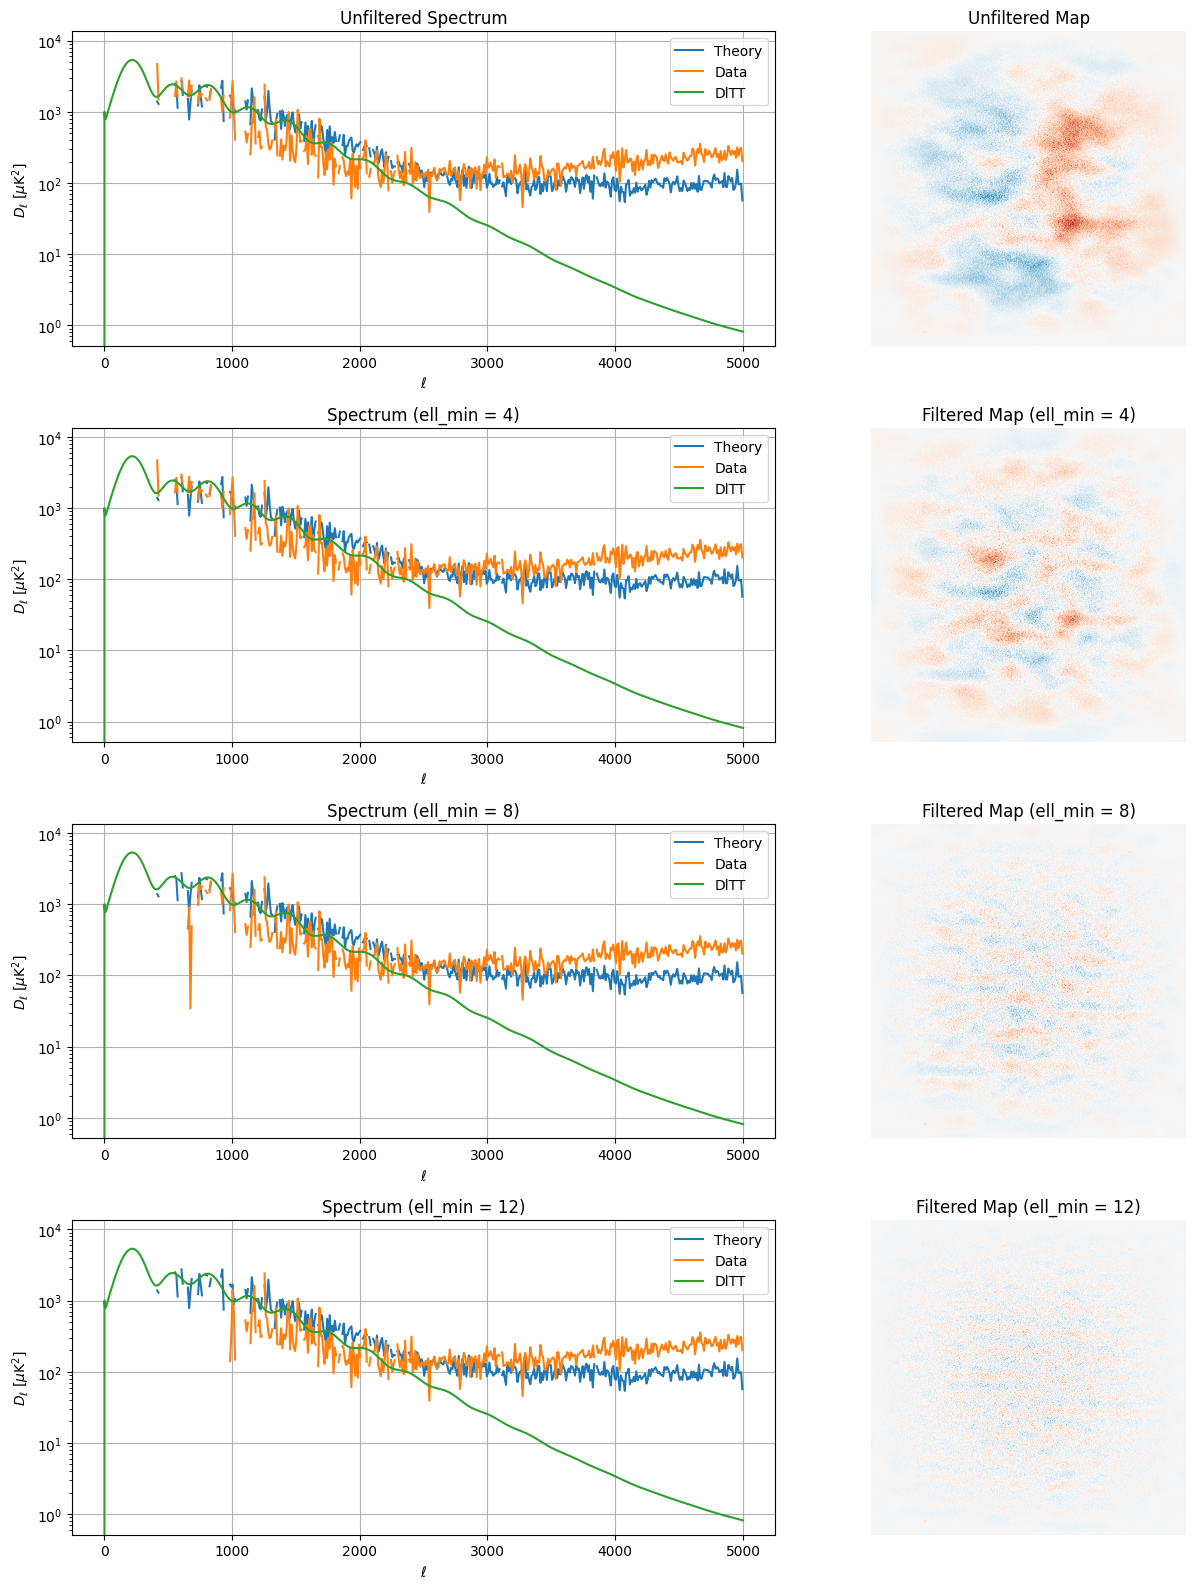

In [35]:
# Assuming cmb_modules and other necessary variables are already defined
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Define a list of ell_min values including 'None' to represent the unfiltered case
ell_min_values = [None, 4, 8, 12]

# Create a figure with two columns: one for the power spectrum and one for the map
fig, axes = plt.subplots(len(ell_min_values), 2, figsize=(14, 4 * len(ell_min_values)))

# Placeholder to store y-axis limits of the unfiltered spectrum
ymin, ymax = None, None

# Loop through each ell_min value to plot spectra and filtered maps
for i, ell_min in enumerate(ell_min_values):
    if ell_min is None:
        filtered_map = unfiltered_map  # Use the original unfiltered map
        title_spectrum = 'Unfiltered Spectrum'
        title_map = 'Unfiltered Map'
    else:
        filtered_map = filter_large_scale_modes(unfiltered_map, ell_min)
        title_spectrum = f'Spectrum (ell_min = {ell_min})'
        title_map = f'Filtered Map (ell_min = {ell_min})'

    # Compute the 2D spectrum using your provided function
    binned_ell_theory, binned_spectrum_theory = cmb_modules.calculate_2d_spectrum(
        appodized_theory_map, appodized_theory_map, delta_ell, ell_max, pix_size, N
    )
    binned_ell_dat, binned_spectrum_dat = cmb_modules.calculate_2d_spectrum(
        filtered_map, filtered_map, delta_ell, ell_max, pix_size, N
    )
    
    # Plot theory and data spectra in the left column
    ax_spectrum = axes[i, 0]
    ax_spectrum.semilogy(binned_ell_theory, binned_spectrum_theory * binned_ell_theory * (binned_ell_theory + 1.) / 2. / np.pi, label='Theory')
    ax_spectrum.semilogy(binned_ell_dat, binned_spectrum_dat * binned_ell_dat * (binned_ell_dat + 1.) / 2. / np.pi, label='Data')
    ax_spectrum.semilogy(ell, DlTT, label='DlTT')
    ax_spectrum.set_title(title_spectrum)
    ax_spectrum.set_xlabel('$\ell$')
    ax_spectrum.set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
    ax_spectrum.legend()
    ax_spectrum.grid()

    # Determine the y-axis limits for the unfiltered spectrum
    if ell_min is None:
        ymin, ymax = ax_spectrum.get_ylim()  # Store the y-axis limits for the unfiltered map
    else:
        # Set the y-axis limits of filtered spectra to match the unfiltered spectrum
        ax_spectrum.set_ylim([ymin, ymax])

    # Plot the filtered map in the right column
    ax_map = axes[i, 1]
    im = ax_map.imshow(filtered_map, cmap=cm.RdBu_r)
    ax_map.set_title(title_map)
    ax_map.axis('off')

plt.tight_layout()
plt.show()


#  shape of the apodising window and the large scale power leaking to small scales.

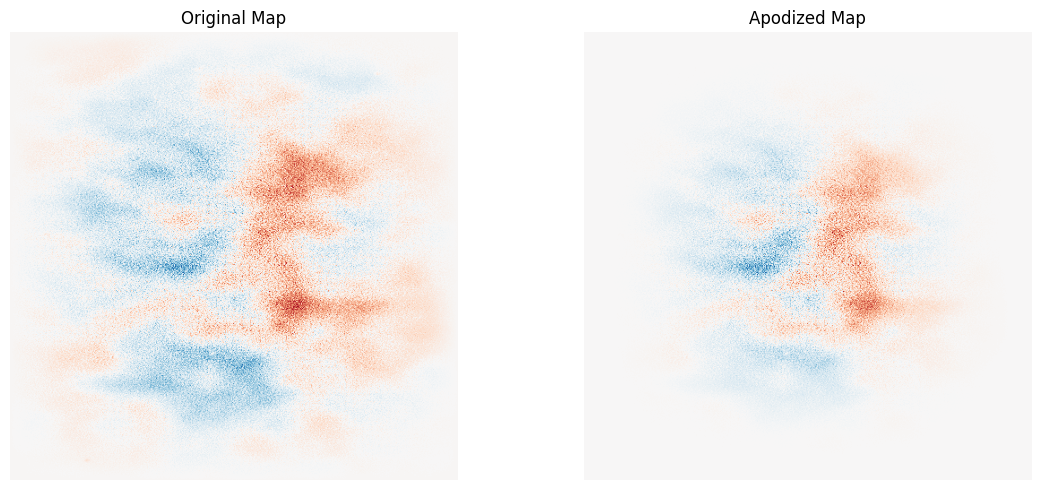

In [39]:
# Function to apply an apodizing window to the map
def apply_apodization(map_data, window_type='cosine'):
    ny, nx = map_data.shape
    y, x = np.ogrid[:ny, :nx]
    
    # Define the apodizing window
    if window_type == 'cosine':
        # Cosine taper window (e.g., Hanning)
        window_y = 0.5 * (1 - np.cos(2 * np.pi * y / (ny - 1)))
        window_x = 0.5 * (1 - np.cos(2 * np.pi * x / (nx - 1)))
        window = window_y * window_x
    elif window_type == 'gaussian':
        # Gaussian window with sigma as a fraction of the map size
        sigma_y = ny / 8.0
        sigma_x = nx / 8.0
        window = np.exp(-((y - ny / 2.0)**2 / (2 * sigma_y**2) + (x - nx / 2.0)**2 / (2 * sigma_x**2)))
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    # Apply the apodizing window to the map
    apodized_map = map_data * window
    return apodized_map

# Apply an apodization to the mock map to reduce ringing effects
apodized_map = apply_apodization(unfiltered_map, window_type='cosine')

# Plot the original and apodized map for comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(unfiltered_map, cmap=cm.RdBu_r)
plt.title('Original Map')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(apodized_map, cmap=cm.RdBu_r)
plt.title('Apodized Map')
plt.axis('off')

plt.tight_layout()
plt.show()


/opt/anaconda3/envs/my_x86_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/my_x86_env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


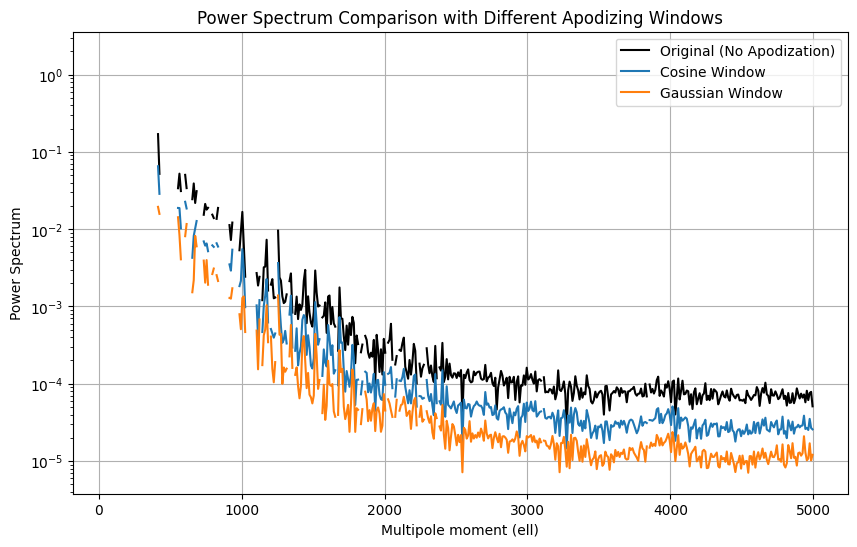

In [43]:
# Define different types of apodizing windows to compare
window_types = ['cosine', 'gaussian']

# Placeholder to store power spectra for different window types
power_spectra = {}

# Loop through each window type and compute the power spectrum for the apodized map
for window_type in window_types:
    # Apply the apodizing window to the map
    apodized_map = apply_apodization(unfiltered_map, window_type=window_type)

    # Compute the 2D power spectrum using the apodized map
    binned_ell, binned_spectrum = cmb_modules.calculate_2d_spectrum(
        apodized_map, apodized_map, delta_ell, ell_max, pix_size, N
    )

    # Store the power spectrum for the current window type
    power_spectra[window_type] = (binned_ell, binned_spectrum)

# Compute the power spectrum for the original (unapodized) map for comparison
ell_original, ps_original = cmb_modules.calculate_2d_spectrum(
        unfiltered_map, unfiltered_map, delta_ell, ell_max, pix_size, N
    )

# Plot the power spectrum for the original and different apodized maps
plt.figure(figsize=(10, 6))

# Plot the original map's power spectrum
plt.plot(ell_original, ps_original, label='Original (No Apodization)', color='black')

# Plot the power spectra for different apodizing windows
for window_type in window_types:
    binned_ell, binned_spectrum = power_spectra[window_type]
    plt.plot(binned_ell, binned_spectrum, label=f'{window_type.capitalize()} Window')

plt.xlabel('Multipole moment (ell)')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum Comparison with Different Apodizing Windows')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()


# I want to quantify the discrepancy of the theory and data by using $\chi^2 = \sum_{i} \frac{\left( \text{Data}_i - \text{Theory}_i \right)^2}{\sigma_i^2}$.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

# Firstly, I want to fit the both data and theory points by polynomial and then resampling them to have same shape

In [58]:
def fit_and_resample_poly(ell_data, C_l_data, ell_theory, C_l_theory, num_points=100):
    """
    Fits the theoretical model to the observed data using polynomial interpolation,
    resamples both datasets to have the same shape, and calculates the Chi-squared statistic.
    
    Parameters:
    - ell_data: Multipole moments for the observed data.
    - C_l_data: Observed power spectrum values.
    - ell_theory: Multipole moments for the theoretical model.
    - C_l_theory: Theoretical power spectrum values.
    - num_points: Number of points for resampling.
    
    Returns:
    - resampled_ell: Resampled ell values.
    - resampled_C_l_data: Resampled observed spectrum.
    - resampled_C_l_fit: Fitted theoretical spectrum.
    - chi_squared: Chi-squared statistic.
    - popt: Optimal parameters from curve fitting.
    """
    # Clean the input data by removing NaNs and Infs
    valid_data_indices = np.isfinite(ell_data) & np.isfinite(C_l_data)
    ell_data = ell_data[valid_data_indices]
    C_l_data = C_l_data[valid_data_indices]
    
    valid_theory_indices = np.isfinite(ell_theory) & np.isfinite(C_l_theory)
    ell_theory = ell_theory[valid_theory_indices]
    C_l_theory = C_l_theory[valid_theory_indices]
    
    # Ensure there's data left after cleaning
    if len(ell_data) == 0 or len(ell_theory) == 0:
        raise ValueError("Cleaned data has no valid entries.")
    
    # Step 2: Define the range for resampling
    min_ell = max(min(ell_data), min(ell_theory))
    max_ell = min(max(ell_data), max(ell_theory))
    resampled_ell = np.linspace(min_ell, max_ell, num_points)
    
    # setting degrees of polynomial, 3 seems okay 
    degree = 3
    # poly fitting 
    theory_coeff = np.polyfit(np.log(ell_theory), np.log(C_l_theory), degree)    # note as the data is showing a log scale, we also have to fitting on a logged data
    data_coeff = np.polyfit(np.log(ell_data), np.log(C_l_data), degree)
    # Generate the polynomial function and resampling 
    theory_poly = np.poly1d(theory_coeff)
    data_poly = np.poly1d(data_coeff)
    resampled_C_l_fit_log = theory_poly(np.log(resampled_ell))
    resampled_C_l_data_log= data_poly(np.log(resampled_ell))
    
    resampled_C_l_fit = np.exp(resampled_C_l_fit_log)
    resampled_C_l_data= np.exp(resampled_C_l_data_log)


    # Step 8: Calculate the Chi-squared statistic
    chi_squared = np.sum(((resampled_C_l_data - resampled_C_l_fit) ** 2) / resampled_C_l_fit)
    
    return resampled_ell, resampled_C_l_data, resampled_C_l_fit, chi_squared


In [59]:
resampled_ell, resampled_C_l_data, resampled_C_l_fit, chi2= fit_and_resample_poly(binned_ell_dat, binned_spectrum_dat, binned_ell_theory, binned_spectrum_theory, num_points=1000)

# Let's make some plots and see how is the fitting and resampling works

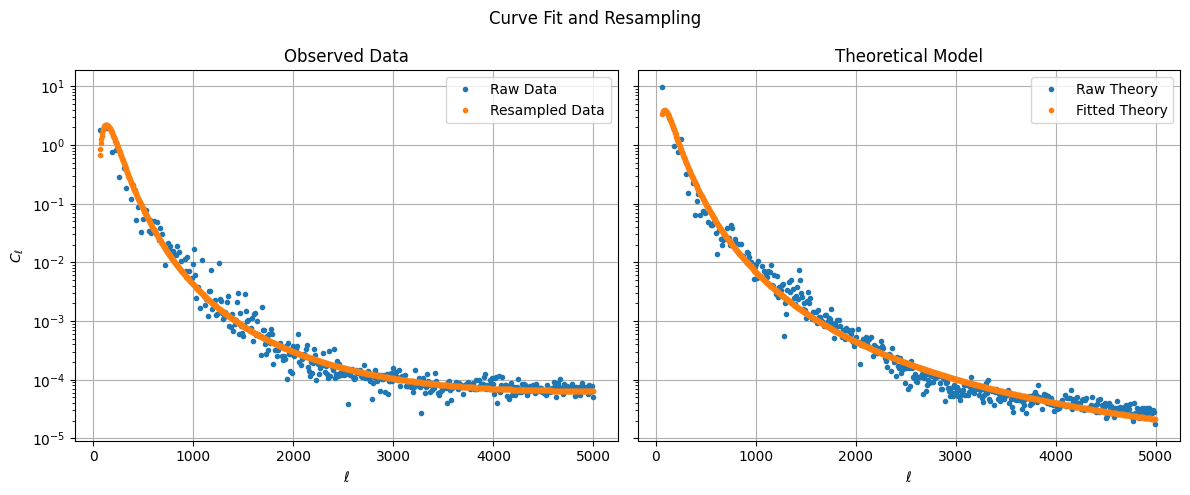

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1: Observed data
ax1.semilogy(binned_ell_dat, binned_spectrum_dat, '.', label='Raw Data')
ax1.semilogy(resampled_ell, resampled_C_l_data, '.', label='Resampled Data')
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$C_\ell$')
ax1.set_title('Observed Data')
ax1.legend()
ax1.grid(True)

# Plot 2: Theoretical model
ax2.semilogy(binned_ell_theory, binned_spectrum_theory, '.', label='Raw Theory')
ax2.semilogy(resampled_ell, resampled_C_l_fit, '.', label='Fitted Theory')
ax2.set_xlabel(r'$\ell$')
ax2.set_title('Theoretical Model')
ax2.legend()
ax2.grid(True)

# Adjust layout and show the plots
plt.suptitle('Curve Fit and Resampling')
plt.tight_layout()
plt.show()

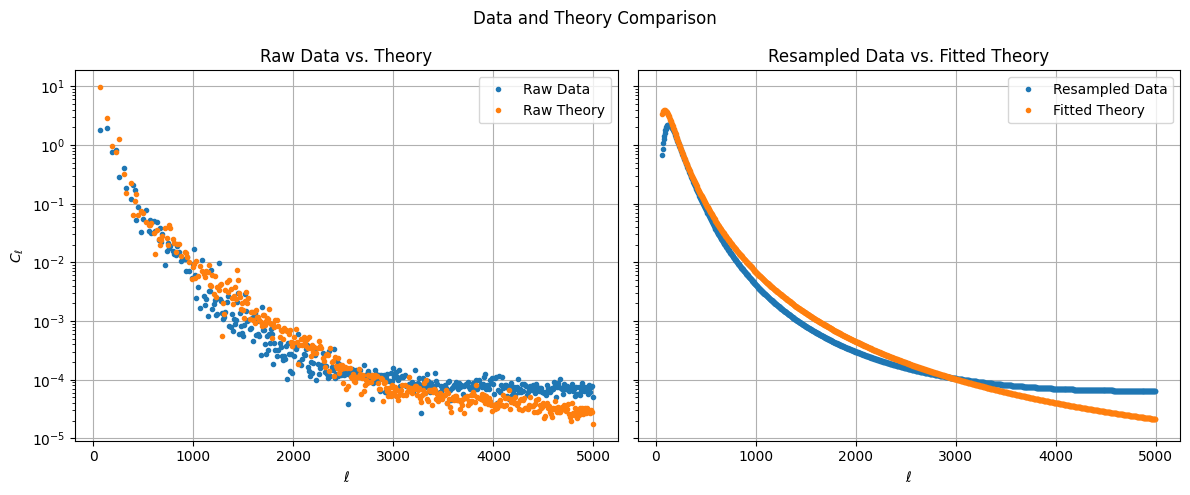

In [65]:
import matplotlib.pyplot as plt

# Create a figure with two subplots arranged side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1: Raw data vs. raw theory
ax1.semilogy(binned_ell_dat, binned_spectrum_dat, '.', label='Raw Data')
ax1.semilogy(binned_ell_theory, binned_spectrum_theory, '.', label='Raw Theory')
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$C_\ell$')
ax1.set_title('Raw Data vs. Theory')
ax1.legend()
ax1.grid(True)

# Plot 2: Resampled data vs. resampled fit
ax2.semilogy(resampled_ell, resampled_C_l_data, '.', label='Resampled Data')
ax2.semilogy(resampled_ell, resampled_C_l_fit, '.', label='Fitted Theory')
ax2.set_xlabel(r'$\ell$')
ax2.set_title('Resampled Data vs. Fitted Theory')
ax2.legend()
ax2.grid(True)

# Adjust layout and show the plots
plt.suptitle('Data and Theory Comparison')
plt.tight_layout()
plt.show()


# They all looks amazing. How about lets make a power spectrum $\chi^2$ map? and we can make a direct comparison with DR5 map. 

#1. make a function to calculate $\chi^2$

In [147]:
def chisquare(i, j, N):
    """""This function calculate the chi^2 based on the given corrdinates i, j on the CMB map. N is the patch size or box size"""
    map_patch = map[i*N:(i+1)*N,j*N:(j+1)*N] #trimming the map down to size

    # Making a window function, taking the shorter dimension for now
    window = (cmb_modules.cosine_window(N))
    appodized_map = window * map_patch
    #p=cmb_modules.Plot_CMB_Map(appodized_map,c_min,c_max,N, N)


    #### parameters for setting up the spectrum
    delta_ell = 10# cs.delta_ell
    ell_max = cs.ell_max
    #ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
    #plt.clf()

    if max(ell)< ell_max: 
            print('WARNING: Your theory curves end before the binned ell_max')
            

    # calculate theory and data power spectrum
    binned_ell_theory, binned_spectrum_theory = \
        cmb_modules.calculate_2d_spectrum(appodized_theory_map,appodized_theory_map,delta_ell,ell_max,pix_size,N)
    binned_ell_dat, binned_spectrum_dat = \
        cmb_modules.calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)
        
    # get the chi^2 from the function we made earlier
    resampled_ell, resampled_C_l_data, resampled_C_l_fit, chi2= fit_and_resample_poly(binned_ell_dat, binned_spectrum_dat, binned_ell_theory, binned_spectrum_theory, num_points=1000)

    return chi2
    




2. make a 2D array which has the same size of DR5 map and divide them into 500*500 squares. We then calculate the chi^2 and store the value into array,

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# the map size, I rounded to the 500 
height, width = 10000, 43000

#  Define the size of each square (500 x 500)
square_size = 500
num_rows = (height // square_size ) 
num_cols = (width // square_size ) 

# Create an array to store the computed values for each square
square_values = np.zeros((num_rows, num_cols))

# Loop through the grid and compute a value for each square
for i in range(num_rows):
    for j in range(num_cols):
        # Extract the 500x500 block
        #block = map_data[i * square_size:(i + 1) * square_size,
                        # j * square_size:(j + 1) * square_size]
        # Compute a value (e.g., mean of the block)
        chi2 = chisquare(i, j,square_size)
        square_values[i, j] = chi2
        print(i,j,chi2)

np.savetxt("chisquaremap_ACT_DR5.txt", square_values, delimiter=',', fmt='%.6f')

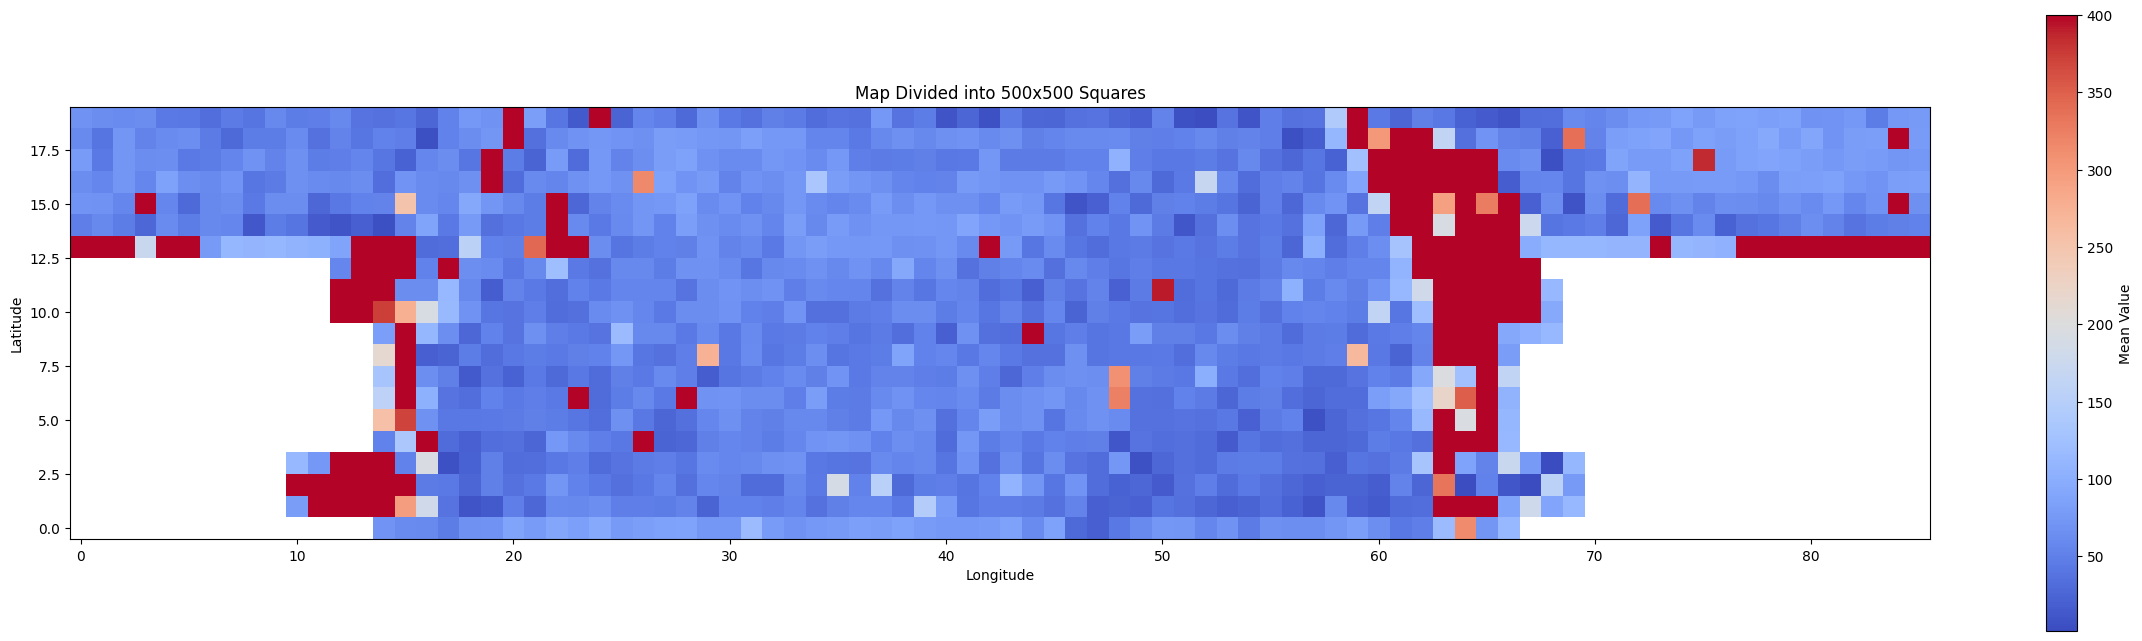

In [156]:
plt.figure(figsize=(30, 8))
plt.imshow(square_values, vmax = 400, cmap='coolwarm', origin='lower')
plt.colorbar(label='Mean Value')
plt.title('Map Divided into 500x500 Squares')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.grid(False)
plt.show()

# Voila! map looks amazing, let's plot it with DR5 map

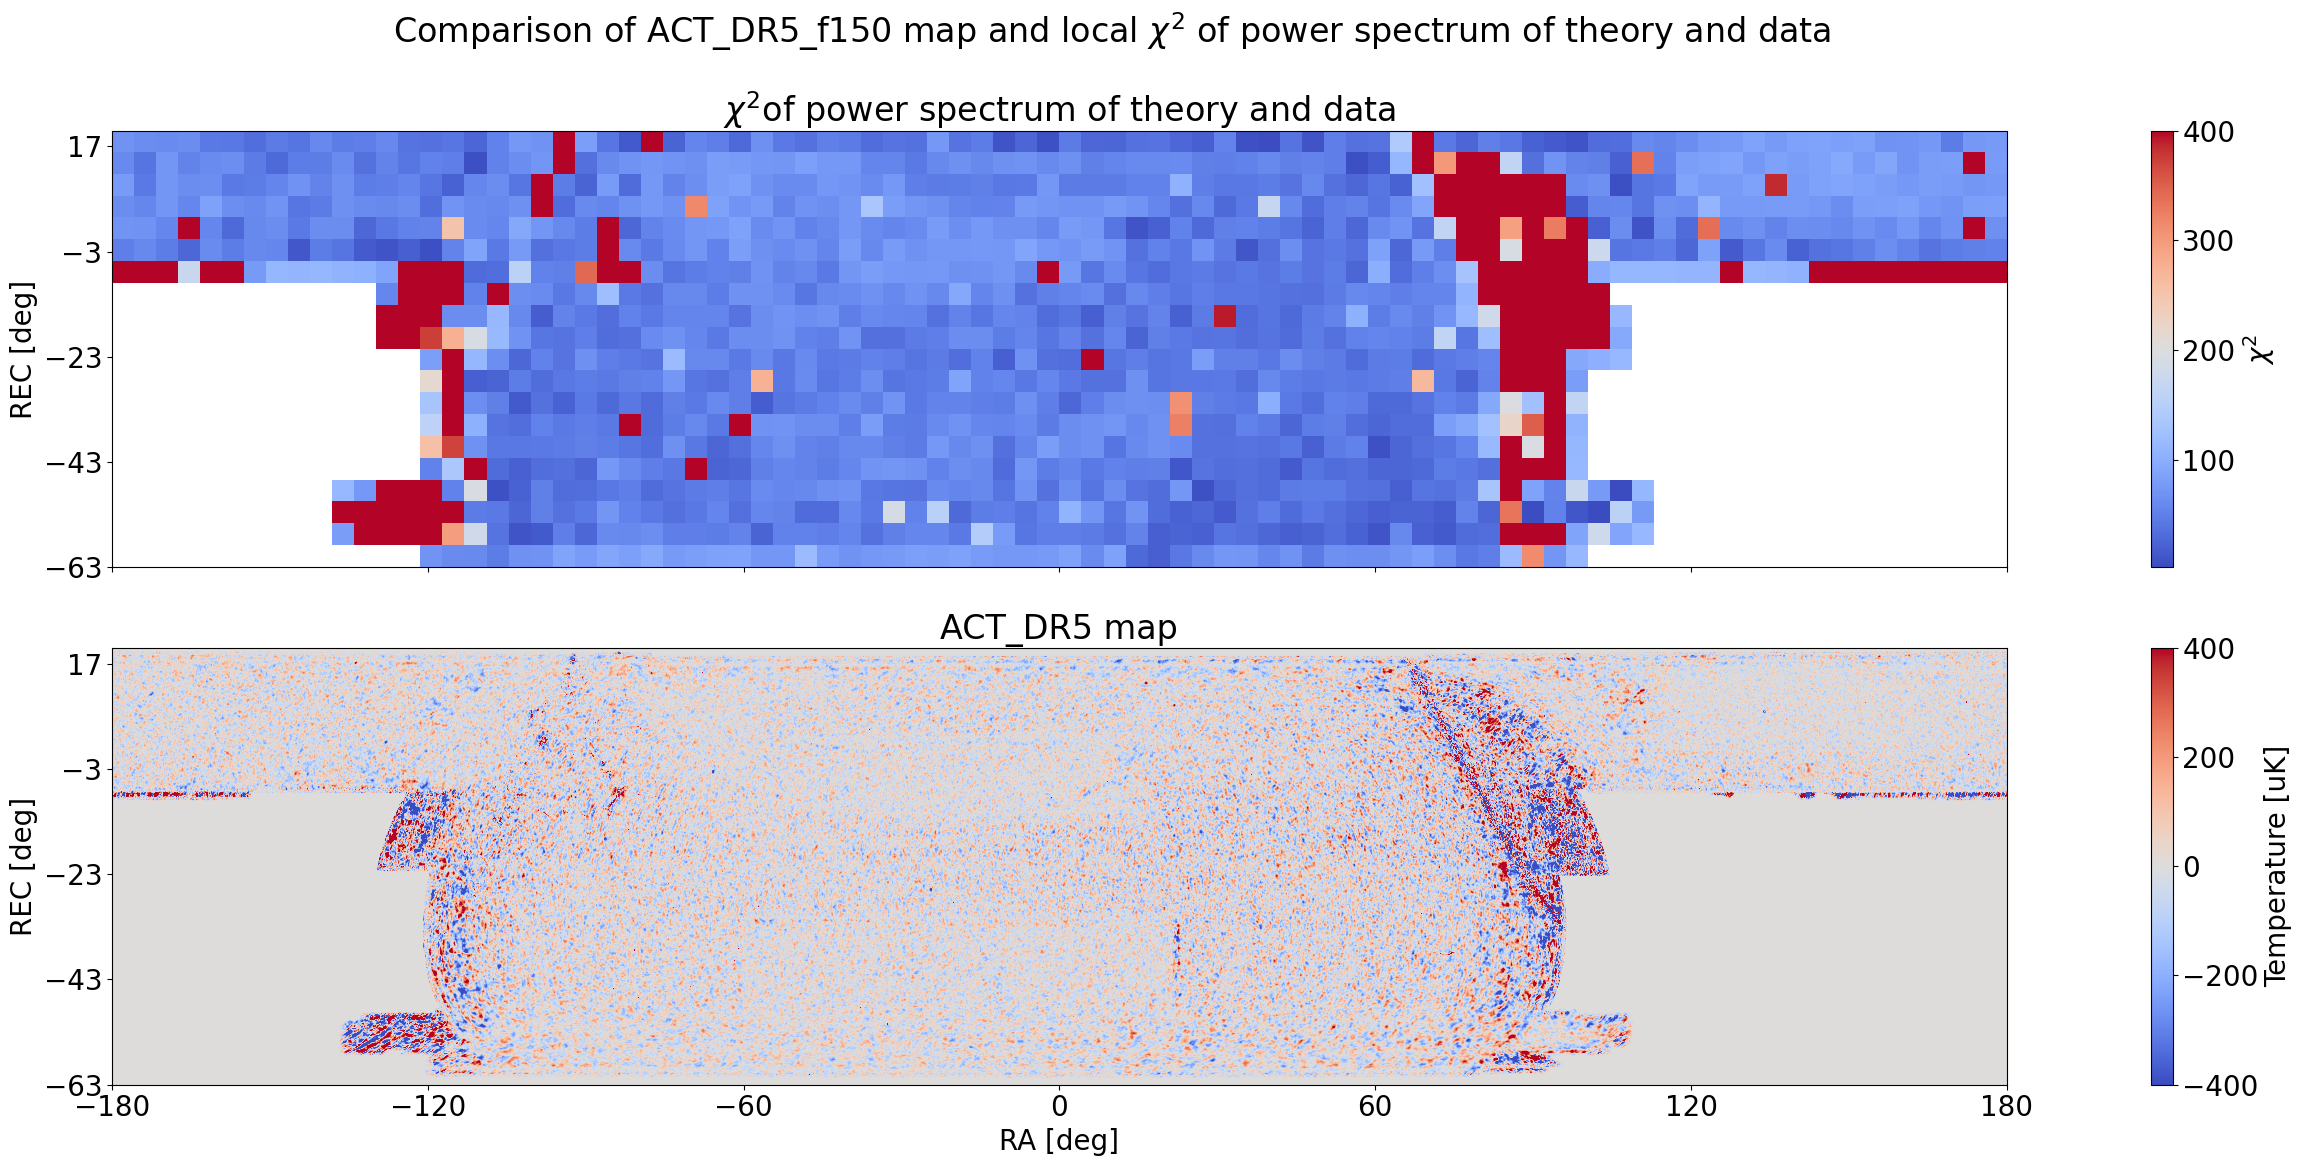

In [170]:

# Define the x and y axis limits
x_extent = (-180, 180)  # Longitude range
y_extent = (-63, 20)    # Latitude range


# Step 2: Define a figure with two subplots side by side, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 12), sharex=True)
plt.rcParams.update({'font.size': 20})
# Step 3: Plot the first map using imshow with shared x-axis
im1 = ax1.imshow(square_values, vmax = 400, cmap='coolwarm', interpolation = 'nearest', origin='lower', extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]])
ax1.set_title('$\chi^2$of power spectrum of theory and data')
#ax1.set_xlabel('RA')
ax1.set_ylabel('REC [deg]')
plt.colorbar(im1, ax=ax1, orientation='vertical', label="$\chi^2$")

# Step 4: Plot the second map using imshow
im2 = ax2.imshow(map, vmax = 400, vmin = -400, cmap='coolwarm', origin='lower', extent=[x_extent[0], x_extent[1], y_extent[0], y_extent[1]])
ax2.set_title('ACT_DR5 map')
ax2.set_xlabel('RA [deg]')
ax2.set_ylabel('REC [deg]')
plt.colorbar(im2, ax=ax2, orientation='vertical', label="Temperature [uK]")

# Step 5: Set custom x-ticks and y-ticks
x_ticks = np.arange(-180, 181, 60)  # Longitude ticks every 60 degrees
y_ticks = np.arange(-63, 21, 20)    # Latitude ticks from -63 to 20 degrees

for ax in [ax1, ax2]:
    ax.set_yticks(y_ticks)
    ax.tick_params(axis='both', labelsize=20)  # Increase tick label font size
ax2.set_xticks(x_ticks)  # Set x-ticks only on the bottom plot
ax2.tick_params(axis='x', labelsize=20)  # Increase x-tick font size

# Step 6: Adjust layout and display the plots
plt.suptitle('Comparison of ACT_DR5_f150 map and local $\chi^2$ of power spectrum of theory and data')
plt.tight_layout()
plt.show()


# Observation 

- We see $\chi^2$ map and DR5 map do have tight corresponding relations which is very cool.
- There are big red regions on the edge of the map which I believe is caused by hardward effects. As this analysis method only applies for flat approximation.
- $\chi^2$ map indicates there are some regions in the middle is vastly deviate from theory power spectrum.

# Meaning of power spectrum $\chi^2$ map

- This could be a potential way to select sources from CMB map. 
- This is an intuitive way to tell which region on the CMB map has bizarr pattern. 

# Next step

1. On the code above, we made the auto correlation power spectrum, I'm curious to see what cross correlation will give us.
2. The modeled cmb map is generated from some fiducial point source and sz signal, what if we use the catalogue from SDSS where we can also incoporate mass profile to make a more realistic modeling of CMB map and thus will make $\chi^2$ a more accurate indicater. 
3. Maybe examine the box size dependence of $\chi^2$, we can also overlaping the neiboring box to make a more detailed $\chi^2$ map.

# Higher resolution with small box comparison to the real data.